#Liberies Import

In [24]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, precision_recall_curve,
    confusion_matrix, classification_report, roc_auc_score, roc_curve)

In [32]:
df = pd.read_csv("Loan_default.csv")
df.head()

,LoanID,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,Education,EmploymentType,MaritalStatus,HasMortgage,HasDependents,LoanPurpose,HasCoSigner,Default
0,I38PQUQS96,56,85994,50587,520,80,4,15.23,36,0.44,Bachelor's,Full-time,Divorced,Yes,Yes,Other,Yes,0
1,HPSK72WA7R,69,50432,124440,458,15,1,4.81,60,0.68,Master's,Full-time,Married,No,No,Other,Yes,0
2,C1OZ6DPJ8Y,46,84208,129188,451,26,3,21.17,24,0.31,Master's,Unemployed,Divorced,Yes,Yes,Auto,No,1
3,V2KKSFM3UN,32,31713,44799,743,0,3,7.07,24,0.23,High School,Full-time,Married,No,No,Business,No,0
4,EY08JDHTZP,60,20437,9139,633,8,4,6.51,48,0.73,Bachelor's,Unemployed,Divorced,No,Yes,Auto,No,0


# Exploratory Data Analysis (EDA)

In [ ]:
df.info()

In [33]:
round(df.describe().T, 2)

,count,mean,std,min,25%,50%,75%,max
Age,255347.0,43.50,14.99,18.0,31.00,43.00,56.00,69.0
Income,255347.0,82499.30,38963.01,15000.0,48825.50,82466.00,116219.00,149999.0
LoanAmount,255347.0,127578.87,70840.71,5000.0,66156.00,127556.00,188985.00,249999.0
CreditScore,255347.0,574.26,158.90,300.0,437.00,574.00,712.00,849.0
MonthsEmployed,255347.0,59.54,34.64,0.0,30.00,60.00,90.00,119.0
NumCreditLines,255347.0,2.50,1.12,1.0,2.00,2.00,3.00,4.0
InterestRate,255347.0,13.49,6.64,2.0,7.77,13.46,19.25,25.0
LoanTerm,255347.0,36.03,16.97,12.0,24.00,36.00,48.00,60.0
DTIRatio,255347.0,0.50,0.23,0.1,0.30,0.50,0.70,0.9
Default,255347.0,0.12,0.32,0.0,0.00,0.00,0.00,1.0


# Limpeza de Dados

In [ ]:
# Verificaando se existe valores nulos
df.isnull().sum()

In [ ]:
df.duplicated().sum()

In [34]:
# Removendo o campo "LoanID", pois é apenas um identificador único, não útil para previsão.
df = df.drop('LoanID', axis=1)

#Testes estatisticos

In [ ]:
cols = ['Age', 'Income', 'LoanAmount', 'CreditScore', 'MonthsEmployed']

for col in cols:
    plt.figure(figsize=(15, 4))

    # Histograma com densidade (removendo NaN)
    plt.subplot(1, 2, 1)
    sns.histplot(df[col].dropna(), kde=True, color='skyblue')
    plt.title(f'Distribuição de {col}')
    plt.xlabel(col)
    plt.ylabel('Frequência')

    # Boxplot (removendo NaN)
    plt.subplot(1, 2, 2)
    sns.boxplot(x=df[col].dropna(), color='lightcoral')
    plt.title(f'Boxplot de {col}')
    plt.xlabel(col)

    plt.tight_layout()
    plt.show()

In [ ]:
from scipy.stats import shapiro

cols = ['Age', 'Income', 'LoanAmount', 'CreditScore', 'MonthsEmployed']

for col in cols:
    stat, p = shapiro(df[col])
    print(col)
    print(f"Test Statistic: {stat:.4f}")
    print(f"P-value: {p:.4f}")
    if p > 0.05:
        print(f"A distribuição de {col} parece seguir uma distribuição normal (p > 0.05 - fail to reject H0)")
        print("-" * 90)
    else:
        print(f"A distribuição de {col} NÃO parece seguir uma distribuição normal (p <= 0.05 - reject H0)")
        print("-" * 90)

In [ ]:
sns.countplot(x='Default', data=df)
plt.title("Distribuição da Variável Alvo")
plt.xlabel("Default (0 = Não inadimplente, 1 = Inadimplente)")
plt.ylabel("Contagem")
plt.show()

#Codificação de Variáveis Categóricas

In [35]:
binary_cols = ['HasMortgage', 'HasDependents', 'HasCoSigner']
for col in binary_cols:
    df[col] = df[col].map({'Yes': 1, 'No': 0})

###Ordinal Encoding

In [ ]:
df['Education'].unique()

array(["Bachelor's", "Master's", 'High School', 'PhD'], dtype=object)

In [36]:
maping_of_education={'High School':0,"Bachelor's":1,"Master's":2,'PhD':3}
df['Education']=df['Education'].map(maping_of_education)

###One-Hot Encoding

In [37]:
from sklearn.preprocessing import OneHotEncoder

# Seleciona as colunas categóricas para codificar
categorical_cols = ['EmploymentType', 'MaritalStatus', 'LoanPurpose']

# Inicializa o OneHotEncoder
# handle_unknown='ignore' é útil se houver categorias no conjunto de teste que não estão no conjunto de treinamento
# sparse=False retorna um array numpy denso em vez de uma matriz esparsa
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

# Aplica o One-Hot Encoding nas colunas selecionadas
# O .fit_transform() ajusta o codificador aos dados e transforma os dados
ohe_data = ohe.fit_transform(df[categorical_cols])

# Cria um DataFrame com os dados codificados
# Usamos get_feature_names_out() para obter os nomes das novas colunas criadas pelo OneHotEncoder
ohe_df = pd.DataFrame(ohe_data, columns=ohe.get_feature_names_out(categorical_cols))

# Remove as colunas categóricas originais do DataFrame principal
df = df.drop(categorical_cols, axis=1)

# Concatena o DataFrame original com o DataFrame codificado
df = pd.concat([df, ohe_df], axis=1)

# Exibe as primeiras linhas do DataFrame atualizado para verificar
# print(df.head())
# print(df.info())

get_dummies()

In [ ]:
df = pd.get_dummies(df, columns=[
    'EmploymentType', 'MaritalStatus', 'LoanPurpose'
], drop_first=True)

#Separar em treino e teste

In [38]:
# Separar X (features) e y (alvo)
X = df.drop("Default", axis=1)
y = df["Default"]

# Etapa 1: Divisão treino/teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [39]:
# Ver distribuição original da classe no treino
print("Antes do SMOTE (treino):")
print(y_train.value_counts())

# Etapa 2: Aplicar SMOTE no treino
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Ver distribuição após SMOTE
print("\nDepois do SMOTE (treino):")
print(y_train_resampled.value_counts())

Antes do SMOTE (treino):
Default
0    180555
1     23722
Name: count, dtype: int64

Depois do SMOTE (treino):
Default
0    180555
1    180555
Name: count, dtype: int64


#Padroninazação dos dados

In [40]:
from sklearn.preprocessing import StandardScaler

# Lista de colunas numéricas a padronizar
num_cols = [
    'Age', 'Income', 'LoanAmount', 'CreditScore',
    'MonthsEmployed', 'NumCreditLines', 'InterestRate', 'LoanTerm',
    'DTIRatio',	'Education'
]

# Instanciar e aplicar o scaler
scaler = StandardScaler()

X_train_scaled = X_train_resampled.copy()
X_test_scaled = X_test.copy()

X_train_scaled[num_cols] = scaler.fit_transform(X_train_resampled[num_cols])
X_test_scaled[num_cols] = scaler.transform(X_test[num_cols])

# ❗Não aplique StandardScaler nas colunas binárias (0/1) ou one-hot encoded — isso pode atrapalhar o modelo.

In [ ]:
X_train_scaled[[
    'Age', 'Income', 'LoanAmount', 'CreditScore',
    'MonthsEmployed', 'NumCreditLines', 'InterestRate', 'LoanTerm',
    'DTIRatio', 'Education'
]]

In [ ]:
X_test_scaled[[
    'Age', 'Income', 'LoanAmount', 'CreditScore',
    'MonthsEmployed', 'NumCreditLines', 'InterestRate', 'LoanTerm',
    'DTIRatio', 'Education'
]]

# Machine Learning Models

## Logistic Regression

In [41]:
# Criar o modelo com parâmetros padrão
lr = LogisticRegression(max_iter=1000, random_state=42)
lr.fit(X_train_scaled, y_train_resampled)

y_pred_lr = lr.predict(X_test_scaled)
y_proba_lr = lr.predict_proba(X_test_scaled)[:, 1]  # Probabilidades para a classe 1

Acurácia: 0.7311141570393578
Precisão: 0.22556814184197566
Recall: 0.5405496543584556
F1 Score: 0.31830818109610803
AUC-ROC: 0.712303948048832

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.76      0.83     45139
           1       0.23      0.54      0.32      5931

    accuracy                           0.73     51070
   macro avg       0.58      0.65      0.58     51070
weighted avg       0.84      0.73      0.77     51070



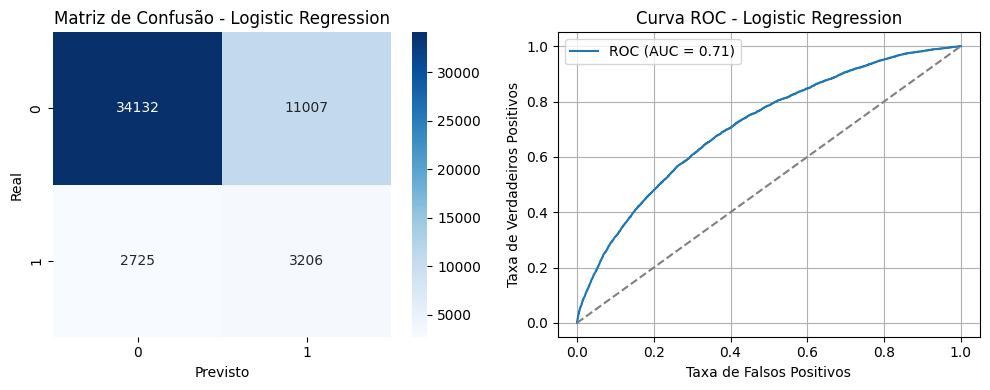

In [42]:
print("Acurácia:", accuracy_score(y_test, y_pred_lr))
print("Precisão:", precision_score(y_test, y_pred_lr))
print("Recall:", recall_score(y_test, y_pred_lr))
print("F1 Score:", f1_score(y_test, y_pred_lr))
print("AUC-ROC:", roc_auc_score(y_test, y_proba_lr))
print("\nClassification Report:\n", classification_report(y_test, y_pred_lr))
# print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Matriz de Confusão e Curva ROC lado a lado
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Matriz de Confusão
sns.heatmap(confusion_matrix(y_test, y_pred_lr), annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title("Matriz de Confusão - Logistic Regression")
axes[0].set_xlabel("Previsto")
axes[0].set_ylabel("Real")

# Curva ROC
fpr, tpr, _ = roc_curve(y_test, y_proba_lr)
axes[1].plot(fpr, tpr, label=f'ROC (AUC = {roc_auc_score(y_test, y_proba_lr):.2f})')
axes[1].plot([0, 1], [0, 1], linestyle='--', color='gray')
axes[1].set_title("Curva ROC - Logistic Regression")
axes[1].set_xlabel("Taxa de Falsos Positivos")
axes[1].set_ylabel("Taxa de Verdadeiros Positivos")
axes[1].legend()
axes[1].grid()

plt.tight_layout()
plt.show()

Best Threshold≈ 0.58
Precisão: 0.24723618090452262
Recall: 0.45624683864441073
F1 Score: 0.32069165127171684


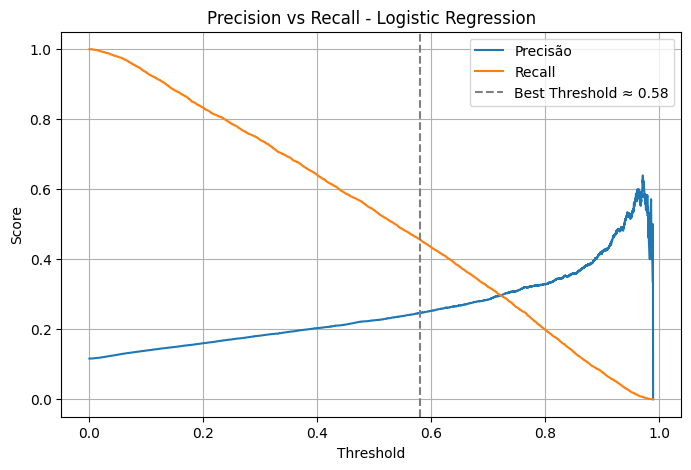

In [ ]:
precision_lr, recall_lr, thresholds_lr = precision_recall_curve(y_test, y_proba_lr)

# Calcular F1 score para cada threshold
f1_scores_lr = 2 * (precision_lr * recall_lr) / (precision_lr + recall_lr + 1e-6)

# Melhor índice de F1
best_idx_lr = np.argmax(f1_scores_lr)
best_threshold_lr = thresholds_lr[best_idx_lr]

print(f"Best Threshold≈ {best_threshold_lr:.2f}")
print("Precisão:", precision_lr[best_idx_lr])
print("Recall:", recall_lr[best_idx_lr])
print("F1 Score:", f1_scores_lr[best_idx_lr])

plt.figure(figsize=(8, 5))
plt.plot(thresholds_lr, precision_lr[:-1], label='Precisão')
plt.plot(thresholds_lr, recall_lr[:-1], label='Recall')
# plt.plot(thresholds_lr, f1_scores_lr[:-1], label='F1 Score', color='purple')

# Marcar o melhor threshold
plt.axvline(best_threshold_lr, color='gray', linestyle='--', label=f'Best Threshold ≈ {best_threshold_lr:.2f}')

plt.title("Precision vs Recall - Logistic Regression")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.legend()
plt.grid()
plt.show()

In [ ]:
y_pred_best_lr = (y_proba_lr >= best_threshold_lr).astype(int)
print(classification_report(y_test, y_pred_best_lr))

              precision    recall  f1-score   support

           0       0.92      0.82      0.87     45139
           1       0.25      0.46      0.32      5931

    accuracy                           0.78     51070
   macro avg       0.58      0.64      0.59     51070
weighted avg       0.84      0.78      0.80     51070



## Random Florest Classifier

In [ ]:
# Instanciar com parâmetros básicos
rf = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train_scaled, y_train_resampled)
y_pred_rf = rf.predict(X_test_scaled)
y_proba_rf = rf.predict_proba(X_test_scaled)[:, 1]

Acurácia: 0.884354807127472
Precisão: 0.528344671201814
Recall: 0.0392851121227449
F1 Score: 0.07313245448838669
AUC-ROC: 0.7292463244605473

Classification Report:
               precision    recall  f1-score   support

           0       0.89      1.00      0.94     45139
           1       0.53      0.04      0.07      5931

    accuracy                           0.88     51070
   macro avg       0.71      0.52      0.51     51070
weighted avg       0.85      0.88      0.84     51070

Confusion Matrix:
 [[44931   208]
 [ 5698   233]]


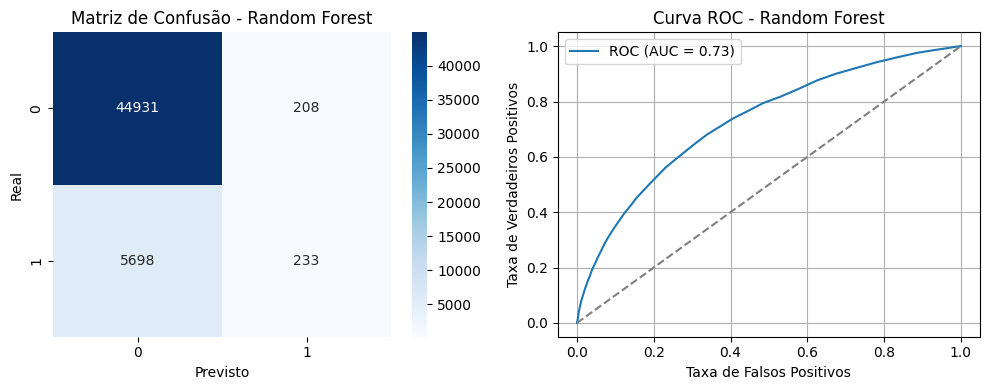

In [ ]:
print("Acurácia:", accuracy_score(y_test, y_pred_rf))
print("Precisão:", precision_score(y_test, y_pred_rf))
print("Recall:", recall_score(y_test, y_pred_rf))
print("F1 Score:", f1_score(y_test, y_pred_rf))
print("AUC-ROC:", roc_auc_score(y_test, y_proba_rf))
print("\nClassification Report:\n", classification_report(y_test, y_pred_rf))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))

# Matriz de Confusão e Curva ROC lado a lado
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Matriz de Confusão
sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title("Matriz de Confusão - Random Forest")
axes[0].set_xlabel("Previsto")
axes[0].set_ylabel("Real")

# Curva ROC
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_proba_rf)
axes[1].plot(fpr_rf, tpr_rf, label=f'ROC (AUC = {roc_auc_score(y_test, y_proba_rf):.2f})')
axes[1].plot([0, 1], [0, 1], linestyle='--', color='gray')
axes[1].set_title("Curva ROC - Random Forest")
axes[1].set_xlabel("Taxa de Falsos Positivos")
axes[1].set_ylabel("Taxa de Verdadeiros Positivos")
axes[1].legend()
axes[1].grid()
plt.tight_layout()
plt.show()

In [ ]:
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'class_weight': ['balanced']
}

rf_base = RandomForestClassifier(random_state=42, n_jobs=-1)

grid_search = GridSearchCV(
    estimator=rf_base,
    param_grid=param_grid,
    scoring='roc_auc',           # você pode trocar por 'recall' ou 'roc_auc'
    cv=3,                   # 3-fold cross-validation
    verbose=2,
    n_jobs=-1
)

grid_search.fit(X_train_scaled, y_train_resampled)

print("Melhores hiperparâmetros encontrados:")
print(grid_search.best_params_)

print("\nMelhor score de validação (F1):")
print(grid_search.best_score_)


In [ ]:
best_rf = grid_search.best_estimator_
y_proba_best_rf = best_rf.predict_proba(X_test_scaled)[:, 1]

# Threshold padrão (0.5) ou ajustado
threshold = 0.5  # ou 0.2, ou 0.1, conforme teste
y_pred_best_rf = (y_proba_best_rf >= threshold).astype(int)

from sklearn.metrics import classification_report, roc_auc_score

print(f"AUC-ROC: {roc_auc_score(y_test, y_proba_best_rf)}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_best_rf))

Hiperparametros Tuning

In [ ]:
# Espaço de busca mais amplo
param_dist = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [None, 10, 20, 30, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False],
    'class_weight': ['balanced']  # Muito importante no seu caso!
}
rf_base = RandomForestClassifier(random_state=42, n_jobs=-1)

random_search = RandomizedSearchCV(
    estimator=rf_base,
    param_distributions=param_dist,
    n_iter=30,                 # número de combinações a testar
    scoring='roc_auc',
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1
)
random_search.fit(X_train_scaled, y_train_resampled)

print("Melhores hiperparâmetros encontrados:")
print(random_search.best_params_)

print("\nMelhor score de validação (roc_auc):")
print(random_search.best_score_)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


KeyboardInterrupt: 

In [ ]:
best_rf_model = random_search.best_estimator_
y_proba_rf_random = best_rf_model.predict_proba(X_test_scaled)[:, 1]

# Threshold ajustado
threshold = 0.3
y_pred_rf_random = (y_proba_rf_random >= threshold).astype(int)

from sklearn.metrics import classification_report, roc_auc_score

print(f"AUC-ROC: {roc_auc_score(y_test, y_proba_rf_random)}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf_random))

scoring='recall'
scoring='roc_auc'

##SGDClassifier

In [ ]:
from sklearn.linear_model import SGDClassifier

sgd = SGDClassifier(
    loss='log_loss',       # Regressão logística
    penalty='l2',
    max_iter=1000,
    tol=1e-3,
    random_state=42,
    class_weight='balanced'
)

sgd.fit(X_train_scaled, y_train_resampled)


SGDClassifier(class_weight='balanced', loss='log_loss', random_state=42)

In [ ]:
y_proba_sgd = sgd.predict_proba(X_test_scaled)[:, 1]
y_pred_sgd = sgd.predict(X_test_scaled)

threshold = 0.5
y_pred_sgd = (y_proba_sgd >= threshold).astype(int)


print(f"AUC-ROC: {roc_auc_score(y_test, y_proba_sgd)}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_sgd))

AUC-ROC: 0.7106394553560367

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.76      0.84     45139
           1       0.23      0.53      0.32      5931

    accuracy                           0.73     51070
   macro avg       0.58      0.65      0.58     51070
weighted avg       0.84      0.73      0.78     51070



In [ ]:
from sklearn.linear_model import SGDClassifier

sgd_svm = SGDClassifier(
    loss='hinge',               # SVM linear
    penalty='l2',
    max_iter=1000,
    tol=1e-3,
    random_state=42,
    class_weight='balanced'
)

sgd_svm.fit(X_train_scaled, y_train_resampled)

SGDClassifier(class_weight='balanced', random_state=42)

In [ ]:
decision_scores = sgd_svm.decision_function(X_test_scaled)
threshold = -0.3  # mais baixo = mais recall
y_pred_svm = (decision_scores >= threshold).astype(int)
# ROC-AUC pode ser calculado com os scores de decisão
print(f"AUC-ROC: {roc_auc_score(y_test, decision_scores)}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_svm))

AUC-ROC: 0.7110756882030917

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.67      0.78     45139
           1       0.20      0.64      0.31      5931

    accuracy                           0.67     51070
   macro avg       0.57      0.65      0.54     51070
weighted avg       0.85      0.67      0.73     51070



Melhor Threshold com base no F1 Score: 0.14
Precisão: 0.23
Recall: 0.50
F1 Score: 0.32


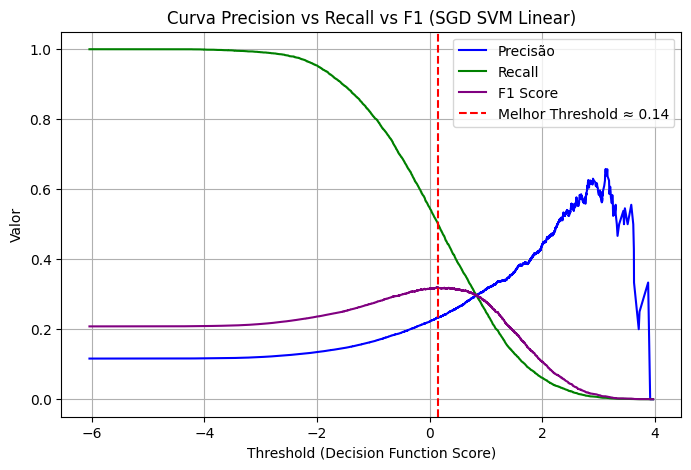

In [ ]:
# Scores de distância da margem
decision_scores = sgd_svm.decision_function(X_test_scaled)
precision, recall, thresholds = precision_recall_curve(y_test, decision_scores)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-6)
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]

print(f"Melhor Threshold com base no F1 Score: {best_threshold:.2f}")
print(f"Precisão: {precision[best_idx]:.2f}")
print(f"Recall: {recall[best_idx]:.2f}")
print(f"F1 Score: {f1_scores[best_idx]:.2f}")

plt.figure(figsize=(8, 5))

plt.plot(thresholds, precision[:-1], label='Precisão', color='blue')
plt.plot(thresholds, recall[:-1], label='Recall', color='green')
plt.plot(thresholds, f1_scores[:-1], label='F1 Score', color='purple')

plt.axvline(best_threshold, color='red', linestyle='--', label=f'Melhor Threshold ≈ {best_threshold:.2f}')

plt.title('Curva Precision vs Recall vs F1 (SGD SVM Linear)')
plt.xlabel('Threshold (Decision Function Score)')
plt.ylabel('Valor')
plt.grid()
plt.legend()
plt.show()

##xgboost

In [ ]:
from xgboost import XGBClassifier
# Contar as classes no conjunto de treino balanceado pelo SMOTE
neg, pos = np.bincount(y_train_resampled)
scale = neg / pos

print(f"Negativos: {neg}, Positivos: {pos}")
print(f"scale_pos_weight: {scale:.2f}")


Negativos: 180555, Positivos: 180555
scale_pos_weight: 1.00


In [ ]:
xgb = XGBClassifier(
    objective='binary:logistic',
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42,
    scale_pos_weight=scale,
    n_jobs=-1
)

xgb.fit(X_train_scaled, y_train_resampled)

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [18:38:53] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=-1,
              num_parallel_tree=None, ...)

In [ ]:
y_proba_xgb = xgb.predict_proba(X_test_scaled)[:, 1]

# Threshold padrão (0.5) ou outro mais agressivo
threshold = 0.5
y_pred_xgb = (y_proba_xgb >= threshold).astype(int)
print(f"AUC-ROC: {roc_auc_score(y_test, y_proba_xgb)}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_xgb))

AUC-ROC: 0.744648433390199

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.99      0.94     45139
           1       0.52      0.09      0.15      5931

    accuracy                           0.88     51070
   macro avg       0.71      0.54      0.55     51070
weighted avg       0.85      0.88      0.85     51070



Melhor Threshold com base no F1: 0.18
Precisão: 0.27
Recall: 0.51
F1 Score: 0.36


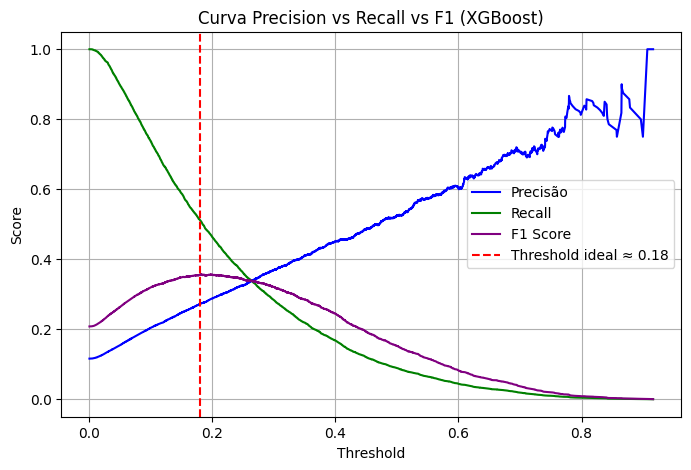

In [ ]:
precision, recall, thresholds = precision_recall_curve(y_test, y_proba_xgb)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-6)
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]

print(f"Melhor Threshold com base no F1: {best_threshold:.2f}")
print(f"Precisão: {precision[best_idx]:.2f}")
print(f"Recall: {recall[best_idx]:.2f}")
print(f"F1 Score: {f1_scores[best_idx]:.2f}")

plt.figure(figsize=(8, 5))
plt.plot(thresholds, precision[:-1], label='Precisão', color='blue')
plt.plot(thresholds, recall[:-1], label='Recall', color='green')
plt.plot(thresholds, f1_scores[:-1], label='F1 Score', color='purple')

# Linha vertical no melhor threshold
plt.axvline(best_threshold, color='red', linestyle='--', label=f'Threshold ideal ≈ {best_threshold:.2f}')

plt.title("Curva Precision vs Recall vs F1 (XGBoost)")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.grid()
plt.legend()
plt.show()